# Import Statements and Loading Data

In [2]:
#Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import textwrap

from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train = pd.read_csv("drive/MyDrive/266Project/train-3.csv")
test = pd.read_csv("drive/MyDrive/266Project/test.csv")
validation = pd.read_csv("drive/MyDrive/266Project/validation.csv")

In [4]:
print(len(train))
print(len(test))
print(len(validation))

3000000
1000000
1000000


# Exploratory Data Analysis and Data Cleaning

In [6]:
#example of text
train.text[0]

'velvet antlers vas are commonly used in traditional chinese medicine and invigorant and contain many PET components for health promotion the velvet antler peptide svap is one of active components in vas based on structural study the svap interacts with tgfÎ² receptors and disrupts the tgfÎ² pathway we hypothesized that svap prevents cardiac fibrosis from pressure overload by blocking tgfÎ² signaling SDRs underwent TAC tac or a sham operation T3 one month rats received either svap mgkgday or vehicle for an additional one month tac surgery induced significant cardiac dysfunction FB activation and fibrosis these effects were improved by treatment with svap in the heart tissue tac remarkably increased the expression of tgfÎ² and connective tissue growth factor ctgf ROS species C2 and the phosphorylation C2 of smad and ERK kinases erk svap inhibited the increases in reactive oxygen species C2 ctgf expression and the phosphorylation of smad and erk but not tgfÎ² expression in cultured cardi

In [7]:
#looking at abbreviation
train.text[0].split()[63]

'TAC'

In [8]:
#looking at structure of location column
train['location'].value_counts()

location
[0]       84375
[1]       38055
[3]       33892
[6]       33524
[5]       33440
          ...  
[613]         1
[583]         1
[577]         1
[1037]        1
[637]         1
Name: count, Length: 767, dtype: int64

In [5]:
#cleaning locations and labels
max_length = 200
max_location = max_length - 3 # minus [CLS] and [SEP] tokens added and index offset

def clean_location(location):
  """Takes a number in brackets as input and returns the number as an int"""
  return int(str(location).strip("[]"))


def clean_label(label):
  """Takes a label in brackets and quotes as input and returns the label as a string"""
  return label.strip("[]'")

  [dataset['location'] <= max_location]


def add_abbreviation_col(dataset):
    """Adds an abbreviation column to the dataset from the specified location in the text"""
    dataset['abbreviation'] = dataset.apply(lambda row: row['text'].split()[row['location']], axis=1)
    return dataset


def clean_dataset(dataset):
    dataset['location'] = dataset['location'].apply(clean_location)
    dataset['label'] = dataset['label'].apply(clean_label)
    dataset = dataset.loc[dataset['location'] <= max_location].copy()
    add_abbreviation_col(dataset)
    return dataset


train = clean_dataset(train)
test = clean_dataset(test)
validation = clean_dataset(validation)

train.head()

,Unnamed: 0,abstract_id,text,location,label,abbreviation
0,0,14145090,velvet antlers vas are commonly used in tradit...,63,transverse aortic constriction,TAC
1,1,1900667,the clinical features of our cases demonstrate...,85,hodgkins lymphoma,HD
2,2,8625554,ceftobiprole bpr is an investigational cephalo...,90,methicillinsusceptible s aureus,MSSA
3,3,8157202,we have taken a basic biologic RPA to elucidat...,26,parathyroid hormonerelated protein,PTHrP
4,4,6784974,lipoperoxidationderived aldehydes for example ...,157,lipoperoxidation,LPO


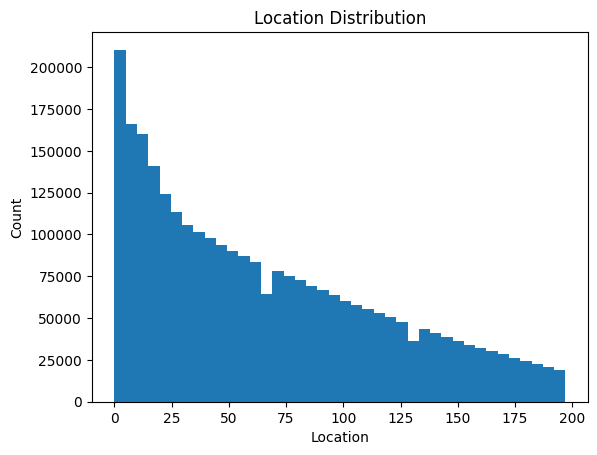

In [6]:
#plotting location
plt.hist(train['location'], bins = 40)
plt.title('Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

In [11]:
#Average length of abbreviation
length = []
for index in range(len(train)):
  length.append(len(train['text'][index].split()[train['location'][index]]))
print(np.average(length))


2.780022


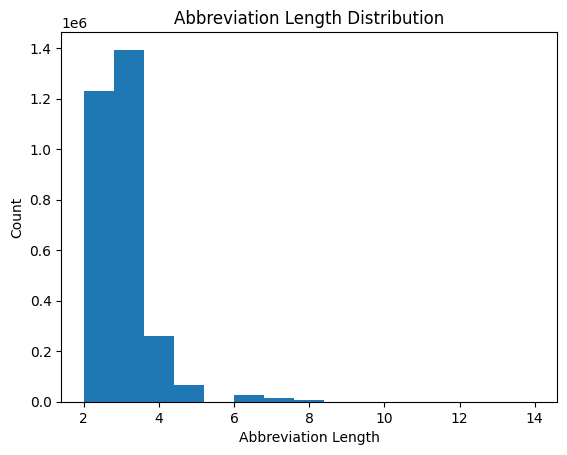

In [12]:
#Plotting distribution of abbreviation lengths
plt.hist(length, bins = 15)
plt.title('Abbreviation Length Distribution')
plt.xlabel('Abbreviation Length')
plt.ylabel('Count')
plt.show()

In [8]:
# How many different labels are there?
print(len(train['label'].unique()))

22555


In [6]:
NUM_ABBREVIATIONS = 100
RANDOM_SEED = 42

random.seed(RANDOM_SEED)

abbreviation_subset = random.sample(list(train.abbreviation.unique()), NUM_ABBREVIATIONS)

In [7]:
#subset the dataset

train_subset = train[train['abbreviation'].isin(abbreviation_subset)]
test_subset = test[test['abbreviation'].isin(abbreviation_subset)]
validation_subset = validation[validation['abbreviation'].isin(abbreviation_subset)]

print(len(train_subset))
print(len(validation_subset))
print(len(test_subset))

49596
16504
16509


In [8]:
label_names = sorted(train_subset.label.unique())
print(f"Size: {len(label_names)}", label_names)

Size: 390 ['active wakefulness', 'active waking', 'adjuvantinduced arthritis', 'aidsassociated retrovirus', 'allylisopropylacetamide', 'aminomethylhimidazofquinoline', 'aminomethylimidazofquinoline', 'anterior wall', 'antigeninduced arthritis', 'antiretroviral', 'ash weight', 'aspirininduced asthma', 'aspirinintolerant asthma', 'average rectified value', 'avian reovirus', 'beauvericin', 'beet yellows closterovirus', 'beet yellows virus', 'belowknee amputation', 'bence jones protein', 'bence jones proteinuria', 'bongkrekic acid', 'bromoethanamine', 'bromoethylamine hydrobromide', 'buffer capacity', 'buffering power', 'calponin homology', 'carbon paste electrode', 'carbonphosphorus', 'carboxypeptidase e', 'cardiac hypertrophy', 'cardiogenic pulmonary edema', 'cell proliferation kinetics', 'central hemodynamics', 'cerebral hemispheres', 'cerebral hemorrhage', 'chediakhigashi', 'chief executive officer', 'childpugh', 'chiral stationary phases', 'chloral hydrate', 'chloroethylene oxide', 'c

In [9]:
del train
del test
del validation

# BERT Base Model


In [10]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture

In [11]:
# tokenize the subset dataset, truncate at `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
def tokenize(text):
    return bert_tokenizer(list(text), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

train_encodings = tokenize(train_subset.text)
valid_encodings = tokenize(validation_subset.text)
test_encodings = tokenize(test_subset.text)


In [12]:
def get_abbrev_token_positions(text, abbrev):
    """
    Takes text and abbreviation and finds the start and end index of the
    tokenized representation of that abbreviation in the text
    """
    tokenized_text = bert_tokenizer.tokenize(text)
    tokenized_abbrev = bert_tokenizer.tokenize(abbrev)
    start = tokenized_text.index(tokenized_abbrev[0])
    end = tokenized_text.index(tokenized_abbrev[-1])
    return start, end


def extract_abbrev_positions_from_dataset(dataset):
    """Extracts all the start and end position of each abbreviation in a dataset"""
    start_positions = []
    end_positions = []
    for i, row in dataset.iterrows():
        start, end = get_abbrev_token_positions(row.text, row.abbreviation)
        start_positions.append(start + 1)  # add 1 to account for CLS token at start
        end_positions.append(end + 1)

    return start_positions, end_positions


train_start_positions, train_end_positions = extract_abbrev_positions_from_dataset(train_subset)
valid_start_positions, valid_end_positions = extract_abbrev_positions_from_dataset(validation_subset)
test_start_positions, test_end_positions = extract_abbrev_positions_from_dataset(test_subset)

In [13]:
def encode_labels(labels):
    return [label_names.index(label) for label in labels]


train_labels = encode_labels(train_subset.label)
valid_labels = encode_labels(validation_subset.label)
test_labels = encode_labels(test_subset.label)

In [14]:
# show original text
print("Text:\n", "\n".join(textwrap.wrap(list(train_subset.text)[0])), "\n")
print("Label:", train_labels[0], label_names[train_labels[0]])

# encoded abbreviation span decoded back to abbreviation text
abbrev_encodings = train_encodings.input_ids[0][train_start_positions[0]:train_end_positions[0]+1]
print("Abbreviation tokens:", bert_tokenizer.decode(abbrev_encodings))

Text:
 propafenone ppf is an antiarrhythmic class ic agent its metabolism is
genetically controlled by a cytochrome p isoenzyme named cypd which
shows polymorphism in human population the aim of this paper was to
determine the correlation between the antiarrhythmic tau of ppf and
the oxidation phenotype subjects and material the study group
consisted of patients aged to years suffering from PAF af the
oxidation phenotype was described by the metabolic ratio mr of
sparteine the mr value separated the group of PMs mr from the group of
extensive metabolizers mr with the subgroup of very extensive
metabolizers mr 

Label: 301 poor metabolizers
Abbreviation tokens: PMs


In [15]:
class ExtractAbbreviationHiddenStates(tf.keras.layers.Layer):
    """
    Custom layer that extracts abbreviation embeddings from BERT
    hidden layer state and position inputs
    """
    def call(self, inputs):
        last_hidden_state, start_abbrev_token_positions, end_abbrev_token_positions = inputs
        batch_size = tf.shape(last_hidden_state)[0]

        span_hidden_states = tf.TensorArray(tf.float32, size=0, dynamic_size=True)

        for i in tf.range(batch_size):
            start_pos = start_abbrev_token_positions[i, 0]
            end_pos = end_abbrev_token_positions[i, 0]
            span_hidden_state = last_hidden_state[i, start_pos:end_pos+1, :]
            span_hidden_states = span_hidden_states.write(i, span_hidden_state)

        return span_hidden_states.stack()


def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = len(label_names),
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    tf.keras.backend.clear_session()
    tf.random.set_seed(RANDOM_SEED)

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')
    start_abbrev_token_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='start_abbreviation_token_positions_layer')
    end_abbrev_token_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='end_abbreviation_token_positions_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_model = TFBertModel.from_pretrained(checkpoint, from_pt=True)

    bert_out = bert_model(bert_inputs)

    last_hidden_state = bert_out.last_hidden_state

    span_hidden_states = ExtractAbbreviationHiddenStates()([last_hidden_state, start_abbrev_token_positions, end_abbrev_token_positions])
    pooled_output = tf.reduce_mean(span_hidden_states, axis=1)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(pooled_output)

    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, start_abbrev_token_positions, end_abbrev_token_positions],
        outputs=[classification],
    )

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [16]:
model = create_bert_multiclass_model()
model.summary()

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 200)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 200)]                0         []                            
 tLayer)                                                                                      

In [ ]:
train_inputs = [
    train_encodings.input_ids,
    train_encodings.token_type_ids,
    train_encodings.attention_mask,
    np.array(train_start_positions),
    np.array(train_end_positions),
]
valid_inputs = [
    valid_encodings.input_ids,
    valid_encodings.token_type_ids,
    valid_encodings.attention_mask,
    valid_start_positions,
    valid_end_positions,
]
history = model.fit(
    train_inputs,
    np.array(train_labels),
    validation_data=(valid_inputs, np.array(valid_labels)),
    batch_size=16,
    shuffle=True,
    verbose=1,
    epochs=2,
)

Epoch 1/2
